In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import trange, tqdm

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform, T3d_2_T2d

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.object import Object
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.register.clipper_pt_registration import ClipperPtRegistration
from object_map_registration.register.dist_vol_sim_reg import DistVolSimReg
from object_map_registration.utils import object_list_bounds

In [15]:
cam_params_pkl = open('/home/masonbp/data/west_point_2023/acl_jackal2_cam_params.pkl', 'rb')
cam_params = pickle.load(cam_params_pkl)
tracker_files = [
    '/home/masonbp/results/west_point_2023/segment_tracking/1117_04.pkl',
    '/home/masonbp/results/west_point_2023/segment_tracking/1117_02.pkl',
]
trackers = [pickle.load(open(f, 'rb')) for f in tracker_files]
num_robots = len(trackers)
assert num_robots <= 2

In [4]:
sol_pkl = "/home/masonbp/results/west_point_2023/frame_align_investigation/test_09/time_10_30/possible_success/solutions.pickle"
clipper_sol = pickle.load(open(sol_pkl, 'rb'))[0][1]
print(clipper_sol.transform)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[[    0.99832   -0.025989    0.051777     0.64622]
 [   0.031947     0.99253    -0.11778     -5.9884]
 [  -0.048329     0.11924     0.99169     -6.4108]
 [          0           0           0           1]]


In [5]:
bags = [
    '/home/masonbp/data/west_point_2023/1117_04_loc_tower_loop_far_side_loop_o3_CCW/align.bag',
    '/home/masonbp/data/west_point_2023/1117_02_map_tower_third_origin/dataset.bag',
]
pose_topic = "/acl_jackal2/kimera_vio_ros/odometry"

pose_data = [PoseData(
    data_file=bag,
    file_type='bag',
    topic=pose_topic,
    time_tol=10.,
    interp=True
) for bag in bags]

pose_data[0].T_premultiply = clipper_sol.transform

In [77]:
def keep_fun(segment: Segment, i: int):
    try:
        cov = segment.covariance()[:2,:2]
        pearson = cov[0,1] / np.sqrt(cov[0,0]*cov[1,1])
        std_devs = 1.
        return np.max([std_devs*np.sqrt(cov[0,0]*(1 + pearson)), std_devs*cov[1,1]*np.sqrt(1 - pearson)]) < 4.0
    except:
        return False
    try:
        return segment.num_sightings > 10 \
            and segment.reconstruction3D(width_height=True)[3] > 0.1 \
            and segment.reconstruction3D(width_height=True)[4] > .1 \
            and (i == 1 or segment.last_seen < tfs[0] - 30)
    except:
        return False

for i in range(num_robots):
    print(f"{i} segments: {len(trackers[i].segments)}")
    print(f"{i} segment graveyard: {len(trackers[i].segment_graveyard)}")

filtered_segments = [[s for s in trackers[i].segment_graveyard if keep_fun(s, i)] for i in range(num_robots)]

print()
for i in range(num_robots):
    print(f"{i} filtered segments: {len(filtered_segments[i])}")

0 segments: 3
0 segment graveyard: 46
1 segments: 1
1 segment graveyard: 34

0 filtered segments: 33
1 filtered segments: 22


(39.55191341504567, 53.256887873562)

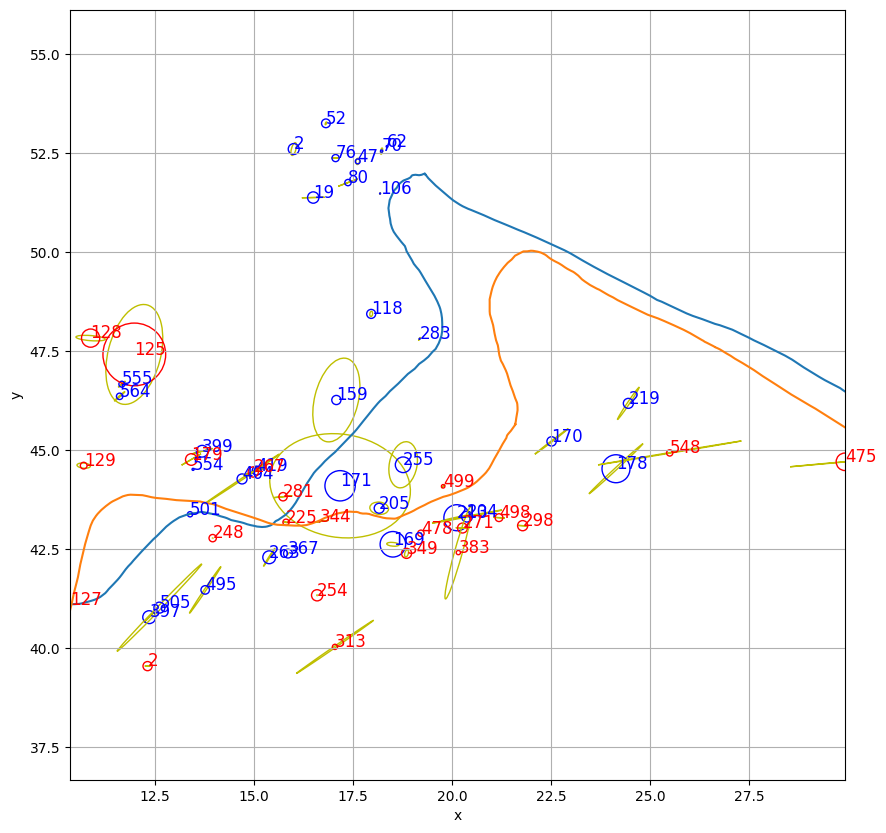

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
maps = [[], []]

formats = ['bx', 'r+']
colors = ['blue', 'red']

for i in range(num_robots):
    # trackers[i].merge()
    for segment in filtered_segments[i]: #trackers[i].segments + trackers[i].segment_graveyard:
        try:
            if segment.num_sightings < 10: continue
            reconstruction = segment.reconstruction3D(width_height=True)
            # position, width = reconstruction[:2], reconstruction[3]
            # ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            position, width, height = reconstruction[:3], reconstruction[3], reconstruction[4]
            
            # ellipsoid = Ellipsoid(reconstruction[:3], axes=np.array([width/2, width/2, height/2]), rot_mat=np.eye(3))
            # if i == 0:
            #     ellipsoid.transform(clipper_sol.transform)

            ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            cov = segment.covariance()[:2,:2]
            pearson = cov[0,1] / np.sqrt(cov[0,0]*cov[1,1])
            cov_ellipse = Ellipsoid(reconstruction[:2], axes=np.array([1*np.sqrt(cov[0,0]*(1 + pearson)), 1*cov[1,1]*np.sqrt(1 - pearson)]), rot_mat=cov[:2,:2])
            if i == 0:
                ellipsoid.transform(T3d_2_T2d(clipper_sol.transform))
                cov_ellipse.transform(T3d_2_T2d(clipper_sol.transform))
            cov_ellipse.plot2d(ax, edgecolor='y')

            maps[i].append(ellipsoid)
            maps[i][-1].plot2d(ax, edgecolor=colors[i])
            plt.text(ellipsoid.centroid[0], ellipsoid.centroid[1], f"{segment.id}", fontsize=12, color=colors[i])
        except:
            print("missed this one")

maps_bounds = object_list_bounds(maps[0] + maps[1])

for pd in pose_data:
    pd.plot2d(tf=pd.tf - 150)

ax.set_xlim(maps_bounds[0])
ax.set_ylim(maps_bounds[1])
# print(maps_bounds)

In [30]:
clipper = ClipperPtRegistration(sigma=.4, epsilon=.6)
inliers_cl = clipper.register(maps[0], maps[1])
print(inliers_cl)

[[ 3 16]
 [ 9  6]
 [ 7 13]
 [21  0]
 [17  7]
 [ 1 12]
 [13  2]]


In [57]:
from motlee.realign.frame_aligner import FrameAligner, AssocMethod
frame_aligner = FrameAligner(
    method=AssocMethod.CLIPPER_MULT_SOL,
    clipper_sigma=.15,
    clipper_epsilon=.3,
    clipper_mult_downweight=0.0,
    clipper_mult_repeats=10
)
centroids1 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[0]])
centroids2 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[1]])
sols = frame_aligner.align_objects(static_objects=[centroids1, centroids2])



In [20]:
map_transformed = []
for obj in maps[1]:
    obj_cp = obj.copy()
    obj_cp.transform(T3d_2_T2d(sols[2].transform))
    map_transformed.append(obj_cp)


In [55]:
dist_vol_reg = DistVolSimReg(sigma=.2, epsilon=.4, vol_score_min=.0, dist_score_min=.0)
inliers = dist_vol_reg.register(maps[0], maps[1])
print(inliers)

[[21  0]
 [ 7 13]
 [ 1 12]]


[[   -0.31513    -0.94905           0      63.826]
 [    0.94905    -0.31513           0      47.419]
 [          0           0           1           0]
 [          0           0           0           1]]


(39.55191341504567, 53.256887873562)

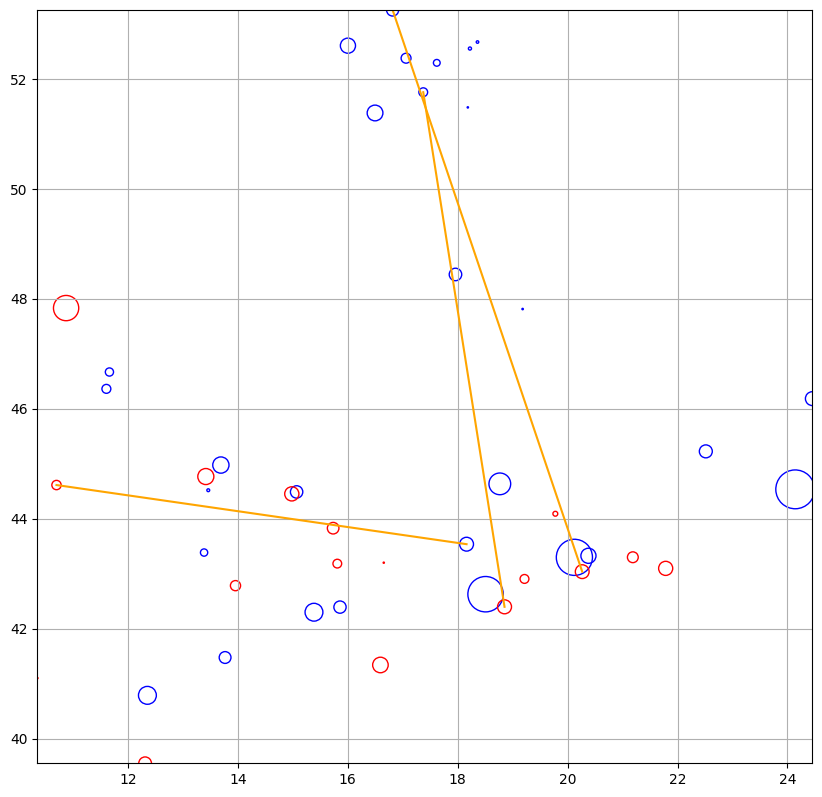

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
colors = ['blue', 'red']
maps_T = [obj.copy() for obj in maps[1]]
i = 9

# for obj in maps_T:
#     obj.transform(T3d_2_T2d(sols[i].transform))


for obj in maps[0]:
    ax = obj.plot2d(ax, edgecolor=colors[0])
for obj in maps_T:
    ax = obj.plot2d(ax, edgecolor=colors[1])

# for pair in inliers:
# # for pair in sols[9].associated_objs:
#     ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], 'g-', linewidth=3)
print(sols[i].transform)
for pair in sols[i].associated_objs:
    ax.plot([maps[0][pair[0]].centroid[0], maps_T[pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps_T[pair[1]].centroid[1]], color='orange')

# for pair in inliers:
#     ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], color='green')


# for pair in inliers_cl:
#     # ax.plot([maps[0][pair[0]].centroid[0], map_transformed[pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], map_transformed[pair[1]].centroid[1]], color='orange')
#     ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], color='orange')
ax.set_xlim(maps_bounds[0])
ax.set_ylim(maps_bounds[1])
